### **1.Introduction**
The task requires participants to automatically predict memorability scores for videos, that reflect the probability for a video to be remembered. Participants will be provided with an extensive data set of videos with memorability annotations, related information, and pre-extracted state-of-the-art visual features.

### **2.Importing Required Packages and Libraries**

In [ ]:
!pip install lightgbm xgboost scikit-learn pandas mlxtend --upgrade

     |████████████████████████████████| 2.0MB 5.3MB/s 
     |████████████████████████████████| 166.7MB 86kB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 9.9MB 52.0MB/s 
     |████████████████████████████████| 1.4MB 43.1MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlx

In [2]:
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn import ensemble
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from mlxtend.regressor import StackingCVRegressor

from keras import Sequential
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold, GridSearchCV

from natsort import natsorted,ns

#Ignoring Warnings
import warnings
warnings.filterwarnings(action="ignore")

### **3 Common Utilities and Function Definition**

#### **3.1 Function to calculate Spearman coefficient scores**

In [21]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s rank correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

#### **3.2 Function to Load C3D and HMP Features**

In [20]:
# loading C3D 
def read_C3D(fname):
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] 
    return C3D
  
# loading HMP
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

#### **3.3 Path of Features To Load From**

In [18]:
# Path for the features
Features_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'

#getting video names using features' name
def getnames(featurename):
  vnames = os.listdir(Features_path+featurename)
  return vnames

#get full path of the features using features' name 
def getpaths(featurename):
  fpath = [Features_path+featurename+'/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [19]:
#load C3D and return as an array of list
def devset_df_C3D():
  path = getpaths('C3D')
  c3d = []
  print('Loading C3D')
  for item in path:
    c3d.append(read_C3D(item))
  print('done')
  return np.asarray(c3d)

#load HMP and return as an array of list
def devset_df_HMP():
  path = getpaths('HMP')
  hmp = []
  print('Loading HMP')
  for item in path:
    hmp.append(read_HMP(item))
  print('done')
  return np.asarray(hmp)

### **4.Loading and Exploring the Data**

### Feature Description (Precomputed Features): 

A set of pre-extracted visual features are provided to the participants to the task.

Precomputed features are organized in different folders, one per feature. 
Most of the time the chosen file format was plain text. We specify the internal feature format for each feature file below.

_Video specialized features_

For the following two features, participants will find one file per video. 

* **C3D** features
  * outputs: the final classification layer of the C3D model
  * file format: text file
  * feature: a single list of numbers on one line (dimension = 101)


* **HMP** 
  * outputs: the histogram of motion patterns for each video
  * file format: text file
  * feature: a single list of pairs of numbers with format: *bin:number* (dimension = 6075) on one line



In [7]:
# connect google drive to this colab session
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive")

Mounted at /content/drive/


In [16]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Dev-set")
!ls

'Aesthetic Features'   HMP				     ORB
 C3D		       HOG				     README.txt
 Captions	       InceptionV3			     Sources
 ColorHistogram        LBP
 Ground-truth	       MemorabilityDataset2018_license.txt


In [9]:
!pwd

/content/drive/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set


#### **4.1 Loading the Ground Truth Labels**####


In [10]:
# examine ground truth
ground_truth_label_loc = 'Ground-truth/ground-truth.csv'
ground_truth = pd.read_csv(ground_truth_label_loc)
ground_truth.head()


,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


#### **4.2 Data Structure of Ground Truth**####

In total, there are 5 columns/variables in the ground truth dataset.
The ground truth dataset consists of character and integer variables.


In [11]:
print("Dimensions of Ground Truth Data:" + str(ground_truth.shape))

Dimensions of Ground Truth Data:(6000, 5)


In [12]:
ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   video                      6000 non-null   object 
 1   short-term_memorability    6000 non-null   float64
 2   nb_short-term_annotations  6000 non-null   int64  
 3   long-term_memorability     6000 non-null   float64
 4   nb_long-term_annotations   6000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 234.5+ KB


In [ ]:
ground_truth.describe().T

,count,mean,std,min,25%,50%,75%,max
short-term_memorability,6000.0,0.860243,0.080655,0.388,0.811,0.867,0.923,0.989
nb_short-term_annotations,6000.0,36.291500,8.356285,30.000,33.000,34.000,34.000,100.000
long-term_memorability,6000.0,0.778942,0.144692,0.000,0.700,0.800,0.900,1.000
nb_long-term_annotations,6000.0,12.764667,3.544815,9.000,10.000,12.000,14.000,40.000


#### **4.3 Loading the C3D Feature Data**####

In [11]:
#loading C3D
feature_C3D = devset_df_C3D()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video3.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video4.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video6.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video8.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/video10.txt']
Loading C3D
done


In [12]:
feature_C3D.shape

(6000, 101)

#### **4.4 Loading the HMP Feature Data**

In [13]:
#loading C3D
feature_HMP = devset_df_HMP()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video3.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video4.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video6.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video8.txt', '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/video10.txt']
Loading HMP
done


In [14]:
feature_HMP.shape

(6000, 6075)

### **5 Exploratory Data Analysis**###

#### **5.1 Checking Missing Data**####

In [ ]:
ground_truth.isnull().sum()

video                        0
short-term_memorability      0
nb_short-term_annotations    0
long-term_memorability       0
nb_long-term_annotations     0
dtype: int64

#### 5.2 **Check for Skeweness in Data**####
Acceptable Range of Skewness and Kurtosis [Normality Testing - Skewness and Kurtosis ](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/).

In [ ]:
# Skew and kurt
print("Skewness of Short Term: %f" % ground_truth['short-term_memorability'].skew())
print("Kurtosis of Short Term: %f" % ground_truth['short-term_memorability'].kurt())

print("Skewness of Long Term: %f" % ground_truth['long-term_memorability'].skew())
print("Kurtosis of Long Term: %f" % ground_truth['long-term_memorability'].kurt())

Skewness of Short Term: -0.949914
Kurtosis of Short Term: 1.246723
Skewness of Long Term: -0.677808
Kurtosis of Long Term: 0.375078


Text(0, 0.5, 'Frequency')

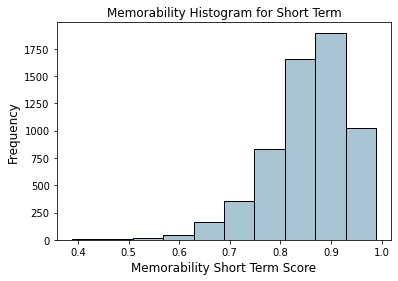

In [ ]:
fig, ax = plt.subplots()
ground_truth['short-term_memorability'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Memorability Histogram for Short Term', fontsize=12)
ax.set_xlabel('Memorability Short Term Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

Text(0, 0.5, 'Frequency')

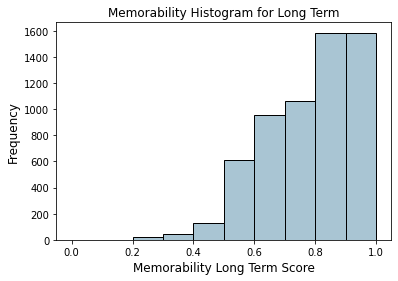

In [ ]:
ground_truth['short-term_memorability'].describe()

count    6000.000000
mean        0.860243
std         0.080655
min         0.388000
25%         0.811000
50%         0.867000
75%         0.923000
max         0.989000
Name: short-term_memorability, dtype: float64

In [ ]:
ground_truth.describe().T

,count,mean,std,min,25%,50%,75%,max
short-term_memorability,6000.0,0.860243,0.080655,0.388,0.811,0.867,0.923,0.989
nb_short-term_annotations,6000.0,36.291500,8.356285,30.000,33.000,34.000,34.000,100.000
long-term_memorability,6000.0,0.778942,0.144692,0.000,0.700,0.800,0.900,1.000
nb_long-term_annotations,6000.0,12.764667,3.544815,9.000,10.000,12.000,14.000,40.000


### **6 Visualizing The Data** ###

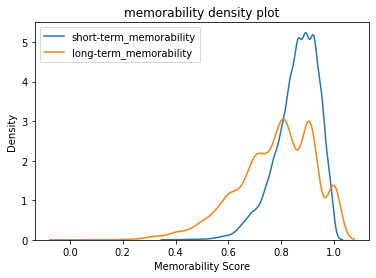

In [ ]:
for memscore in ['short-term_memorability', 'long-term_memorability']:
  sns.distplot(ground_truth[memscore], hist=False, label=memscore)
plt.xlabel('Memorability Score')
plt.title('memorability density plot')
plt.legend(prop={'size': 10})

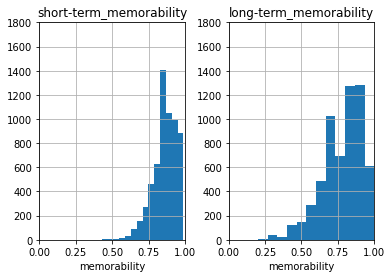

In [ ]:
fig, ax = plt.subplots()
ground_truth['short-term_memorability'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Memorability Histogram for Short Term', fontsize=12)
ax.set_xlabel('Memorability Short Term Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [ ]:
fig, ax = plt.subplots()
ground_truth['long-term_memorability'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Memorability Histogram for Long Term', fontsize=12)
ax.set_xlabel('Memorability Long Term Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

### **7 Model Building and Expermenting Various Models Using C3D Feature**##



#### **7.1 Predicting Lasso Regression Model**####

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = feature_C3D
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:
y_pred = lasso.predict(X_test)
Get_score(y_pred, y_test)


The Spearman's rank correlation coefficient is: 0.309
The Spearman's rank correlation coefficient is: 0.123


#### **7.2 Predicting Using ElasticNet Regression Model**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = feature_C3D
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [ ]:
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.309
The Spearman's rank correlation coefficient is: 0.123


#### **7.3 Predicting Using Gradient Boosting Regressor**####

In [ ]:
Y_short_term = ground_truth[['short-term_memorability']].values # st targets
Y_long_term = ground_truth[['long-term_memorability']].values  # lt targets
X = feature_C3D

# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(X,Y_short_term,test_size=0.1,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(X,Y_long_term,test_size=0.1,random_state=40)

In [ ]:

#Model Params - 650 decision tree, 12 depth, learning rate 0.01
params = {'n_estimators':650, 'max_depth':12, 'min_samples_split':2, 'learning_rate':0.01, 'loss':'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

In [ ]:
#fit to short term training set
clf.fit(short_X_train, short_y_train)
clf.fit(long_X_train, long_y_train)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='lad',
                          max_depth=12, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=650,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#predict for stm for test set
print('Short Term:')
print(Get_score(clf.predict(short_X_test), short_y_test))
#predict for stm for test set
print('Long Term:')
print(Get_score(clf.predict(long_X_test), long_y_test))

Short Term:
The Spearman's rank correlation coefficient is: 0.312
None
Long Term:
The Spearman's rank correlation coefficient is: 0.168
None


#### **7.4 Predicting Using Random Forest**####

In [98]:
X = feature_C3D
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=42,verbose=2)

rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [99]:
rf_pred = rf_regressor.predict(X_test)

Get_score(rf_pred, y_test)

The Spearman's rank correlation coefficient is: 0.337
The Spearman's rank correlation coefficient is: 0.145


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


##### **7.4.a Tuning Hyperparameter using  GridSearchCV and RandomizedSearchCV**#####

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 40, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 5, 9, 13, 17, 21, 24, 28, 32, 36, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 166, 233, 300, 366, 433, 500, 566, 633, 700]}


In [ ]:
X = feature_C3D
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   2.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   2.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=   2.6s
[CV] n_estimators=233, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=32, bootstrap=False 
[CV]  n_estimators=233, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=32, bootstrap=False, total=   9.7s
[CV] n_estimators=233, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=32, bootstrap=False 
[CV]  n_estimators=233, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=32, bootstrap=False, total=   9.7s
[CV] n_estimators=233, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=32, bootstrap=False 
[CV]  n_estimators=233,

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 77.9min finished


'\n#Random Forest\nfrom scipy.stats import randint as sp_randint\nfrom sklearn.model_selection import RandomizedSearchCV\n# Define the hyperparameter configuration space\nrf_params = {\n    \'n_estimators\': sp_randint(10,100),\n    "max_features":sp_randint(1,13),\n    \'max_depth\': sp_randint(5,50),\n    "min_samples_split":sp_randint(2,11),\n    "min_samples_leaf":sp_randint(1,11),\n    "criterion":[\'mse\',\'mae\']\n}\nn_iter_search=20 #number of iterations is set to 20, you can increase this number if time permits\nclf = RandomForestRegressor(random_state=0)\nRandom = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring=\'neg_mean_squared_error\')\nRandom.fit(X_train, y_train)\nprint(Random.best_params_)\nprint("MSE:"+ str(-Random.best_score_))\n'

In [ ]:
# Checking The best parameters using RandomSearchCV
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 366}

In [ ]:
best_random_grid=rf_random.best_estimator_

In [ ]:
y_pred=best_random_grid.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.324
The Spearman's rank correlation coefficient is: 0.175


In [ ]:
Random.best_params_ 

{'criterion': 'mae',
 'max_depth': 22,
 'max_features': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 72}

Random search allowed us to narrow down the range for each hyperparameter. As we have a clear idea to concentrate on our search we will now use **GridSearchCV** to try different combination settings

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [9, 10, 11, 12],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [400, 500, 600, 700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 41.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
best_grid=grid_search.best_estimator_

In [ ]:
y_pred=best_grid.predict(X_test)

Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.342
The Spearman's rank correlation coefficient is: 0.187


#### **7.5 Predicting Using XGBoost Model**####

In [ ]:
Y = ground_truth[['short-term_memorability','long-term_memorability']].values
X = feature_C3D

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42) 

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb = MultiOutputRegressor(model_xgb)
xgb.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.4603,
                                            gamma=0.0468,
                                            importance_type='gain',
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=5,
                                            min_child_weight=1.7817,
                                            missing=None, n_estimators=2200,
                                            n_jobs=1, nthread=-1,
                                            objective='reg:linear',
                                            random_state=7, reg_alpha=0.464,
                                            reg_lambda=0.8571,
                                       

In [ ]:
predictionsXGB = xgb.predict(X_test)
Get_score(predictionsXGB, Y_test)

The Spearman's rank correlation coefficient is: 0.365
The Spearman's rank correlation coefficient is: 0.128


#### **7.6 Predicting Using Multilayer Perceptron Model**####

Epoch 1/50
169/169 [==============================] - 1s 3ms/step - loss: 0.0957 - accuracy: 0.6900 - val_loss: 0.0309 - val_accuracy: 0.6950
Epoch 2/50
169/169 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.6920 - val_loss: 0.0224 - val_accuracy: 0.6950
Epoch 3/50
169/169 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.6994 - val_loss: 0.0207 - val_accuracy: 0.6950
Epoch 4/50
169/169 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.6919 - val_loss: 0.0193 - val_accuracy: 0.6950
Epoch 5/50
169/169 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.6922 - val_loss: 0.0182 - val_accuracy: 0.6950
Epoch 6/50
169/169 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.6974 - val_loss: 0.0174 - val_accuracy: 0.6950
Epoch 7/50
169/169 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.6892 - val_loss: 0.0168 - val_accuracy: 0.6950
Epoch 

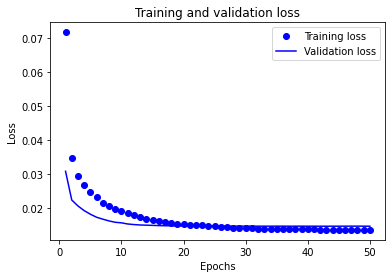

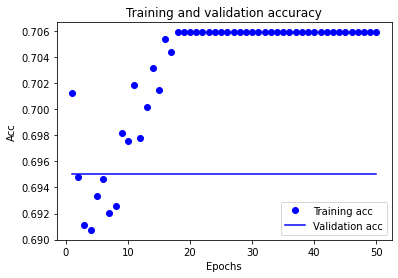

In [ ]:
Y = ground_truth[['short-term_memorability','long-term_memorability']].values
X = feature_C3D
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
## Multi Layer perceptron Model 

model=Sequential() # Create Sequential NN model

## Add layers for MLP
model.add(layers.Dropout(0.6, input_shape=(X.shape[1],))) # add dropout layer

# layer of 10 neurons with selu activation function, L2 Regularization and initial weights as zeros
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001), kernel_initializer='zeros')) 

# layer of 10 neurons with selu activation function and L2 Regularization
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001)))

# add dropout
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2,activation='sigmoid')) ## Last activation as sigmoid to predict score

## Compile the model 
# Optimizer Adamax
model.compile(optimizer='adamax',loss='mse',metrics=['accuracy'])

## Training the model 
history = model.fit(X_train,Y_train,epochs=50, validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

The Spearman's rank correlation coefficient is: 0.305
The Spearman's rank correlation coefficient is: 0.146


#### **7.7 Prediction using Stacking Models for improved prediction**####

In [70]:
Y_st = ground_truth['short-term_memorability'].values # st targets
Y_lt = ground_truth['long-term_memorability'].values # st targets
X = feature_C3D

from sklearn.model_selection import train_test_split
X_train_st, X_test_st, Y_train_st, Y_test_st = train_test_split(X,Y_st, test_size=0.1, random_state=42) 
X_train_lt, X_test_lt, Y_train_lt, Y_test_lt = train_test_split(X,Y_lt, test_size=0.1, random_state=42)

In [43]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [44]:

# XGBoost Regressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=400,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(model_xgb, gbr, rf),
                                meta_regressor=model_xgb,
                                use_features_in_secondary=True)

In [45]:
print('stack_gen')
stack_gen_model = stack_gen.fit(X_train_st, Y_train_st)

stack_gen


In [47]:
print('xgboost')
xgb_model_full_data = model_xgb.fit(X_train_st, Y_train_st)

xgboost


In [48]:
print('RandomForest')
rf_model_full_data = rf.fit(X_train_st, Y_train_st)

RandomForest


In [49]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train_st, Y_train_st)

GradientBoosting


In [56]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * gbr_model_full_data.predict(X_test_st)) + \
            (0.5 * xgb_model_full_data.predict(X_test_st)) + \
            (0.05 * rf_model_full_data.predict(X_test_st)) + \
            (0.35 * stack_gen_model.predict(X_test_st)))

In [55]:
print('Short- Term Score:')
Get_score(blended_predictions(X), Y_test_st)

The Spearman's rank correlation coefficient is: 0.363


In [72]:
#Predicting The Long Term Memorability Score

print('stack_gen')
stack_gen_model = stack_gen.fit(X_train_lt, Y_train_lt)

stack_gen


In [73]:
print('xgboost')
xgb_model_full_data = model_xgb.fit(X_train_lt, Y_train_lt)

xgboost


In [74]:
print('RandomForest')
rf_model_full_data = rf.fit(X_train_lt, Y_train_lt)

RandomForest


In [75]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train_lt, Y_train_lt)

GradientBoosting


In [77]:
 #Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * gbr_model_full_data.predict(X_test_lt)) + \
            (0.5 * xgb_model_full_data.predict(X_test_lt)) + \
            (0.05 * rf_model_full_data.predict(X_test_lt)) + \
            (0.35 * stack_gen_model.predict(X_test_lt)))

In [78]:
print('Long- Term Score:')
Get_score(blended_predictions(X), Y_test_lt)

Long- Term Score:
The Spearman's rank correlation coefficient is: 0.149


### **8 Model Building and Expermenting Various Models Using HMP Feature** ###

#### **8.1 Predicting Lasso Regression Model**####

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = feature_HMP
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:
y_pred = lasso.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.266
The Spearman's rank correlation coefficient is: 0.069


#### **8.2 Predicting using ElasticNet Regression Model** ####

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = feature_HMP
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [ ]:
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.263
The Spearman's rank correlation coefficient is: 0.065


#### **8.3 Predicting using Random Forest**####

In [ ]:
# Using the Best parameters found from Hyperparameter tuning when training with C3D feature

X = feature_HMP
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=400,random_state=42,verbose=2)

rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s


building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 133.1min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [ ]:
rf_pred = rf_regressor.predict(X_test)
Get_score(rf_pred, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


The Spearman's rank correlation coefficient is: 0.311
The Spearman's rank correlation coefficient is: 0.108


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished


####**8.4 Predicting using XGBoost Model** ####

In [100]:
Y = ground_truth[['short-term_memorability','long-term_memorability']].values
X = feature_HMP

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42) 

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb = MultiOutputRegressor(model_xgb)
xgb.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.4603,
                                            gamma=0.0468,
                                            importance_type='gain',
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=4,
                                            min_child_weight=1.7817,
                                            missing=None, n_estimators=2200,
                                            n_jobs=1, nthread=-1,
                                            objective='reg:linear',
                                            random_state=7, reg_alpha=0.464,
                                            reg_lambda=0.8571,
                                       

In [101]:
predictionsXGB = xgb.predict(X_test)
Get_score(predictionsXGB, Y_test)

The Spearman's rank correlation coefficient is: 0.350
The Spearman's rank correlation coefficient is: 0.108


#### **8.5 Predicting Using Multilayer Perceptron Model**####

Epoch 1/60
169/169 [==============================] - 2s 10ms/step - loss: 0.0843 - accuracy: 0.6776 - val_loss: 0.0281 - val_accuracy: 0.6950
Epoch 2/60
169/169 [==============================] - 1s 8ms/step - loss: 0.0382 - accuracy: 0.6681 - val_loss: 0.0221 - val_accuracy: 0.6950
Epoch 3/60
169/169 [==============================] - 1s 9ms/step - loss: 0.0325 - accuracy: 0.6579 - val_loss: 0.0200 - val_accuracy: 0.6950
Epoch 4/60
169/169 [==============================] - 1s 8ms/step - loss: 0.0289 - accuracy: 0.6490 - val_loss: 0.0187 - val_accuracy: 0.6950
Epoch 5/60
169/169 [==============================] - 1s 8ms/step - loss: 0.0258 - accuracy: 0.6728 - val_loss: 0.0178 - val_accuracy: 0.6950
Epoch 6/60
169/169 [==============================] - 1s 9ms/step - loss: 0.0242 - accuracy: 0.6650 - val_loss: 0.0171 - val_accuracy: 0.6950
Epoch 7/60
169/169 [==============================] - 1s 9ms/step - loss: 0.0228 - accuracy: 0.6653 - val_loss: 0.0166 - val_accuracy: 0.6950
Epoch

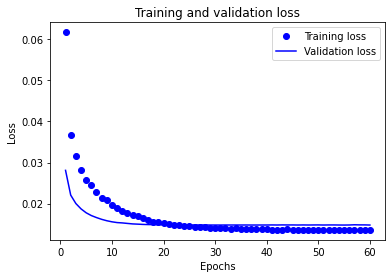

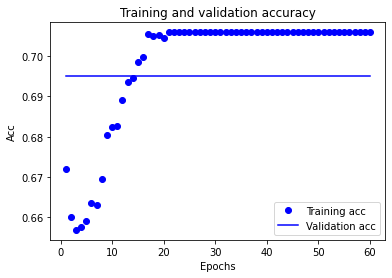

In [ ]:
Y = ground_truth[['short-term_memorability','long-term_memorability']].values
X = feature_HMP;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
## Multi Layer perceptron Model 

model=Sequential() # Create Sequential NN model

## Add layers for MLP
model.add(layers.Dropout(0.6, input_shape=(X.shape[1],))) # add dropout layer

# layer of 10 neurons with selu activation function, L2 Regularization and initial weights as zeros
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001), kernel_initializer='zeros')) 

# layer of 10 neurons with selu activation function and L2 Regularization
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001)))

# add dropout
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2,activation='sigmoid')) ## Last activation as sigmoid to predict score

## Compile the model 
# Optimizer Adamax
model.compile(optimizer='adamax',loss='mse',metrics=['accuracy'])

## Training the model 
# Number of epochs also comes from Gridsearch
history = model.fit(X_train,Y_train,epochs=60, validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

The Spearman's rank correlation coefficient is: 0.149
The Spearman's rank correlation coefficient is: 0.086


### **9 Model Building and Expermenting Various Models Using Combination of C3D and HMP Feature**

#### **9.1 Predicting Using Lasso Regression Model** ####

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = np.concatenate((feature_C3D,feature_HMP), axis=1)
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:
y_pred = lasso.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.278
The Spearman's rank correlation coefficient is: 0.066


#### **9.2 Predicting Using ElasticNet Regression Model**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

X = np.concatenate((feature_C3D,feature_HMP), axis=1)
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [ ]:
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's rank correlation coefficient is: 0.276
The Spearman's rank correlation coefficient is: 0.061


#### **9.3 Predicting using Random Forest**####

In [68]:
# Using the Best parameters found from Hyperparameter tuning when training with C3D feature

X = np.concatenate((feature_C3D,feature_HMP), axis=1)
Y = ground_truth[['short-term_memorability','long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=42,verbose=2,n_jobs=-1)

rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.0min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [69]:
rf_pred = rf_regressor.predict(X_test)

Get_score(rf_pred, y_test)

The Spearman's rank correlation coefficient is: 0.357
The Spearman's rank correlation coefficient is: 0.120


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


####**9.4 Predicting using XGBoost Model** ####

In [21]:
# Predicting Short Term Memorability Score

import xgboost as xgb
Y_st = ground_truth[['short-term_memorability']].values # st targets
X = np.concatenate((feature_C3D,feature_HMP), axis=1)

from sklearn.model_selection import train_test_split
X_train_st, X_test_st, Y_train_st, Y_test_st = train_test_split(X,Y_st, test_size=0.1, random_state=42) 

model_xgb = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X_train_st, Y_train_st)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [22]:
#predict for stm for test set
print('Short Term:')
y_pred = model_xgb.predict(X_test_st)
Get_score(y_pred, Y_test_st)

Short Term:
The Spearman's rank correlation coefficient is: 0.410


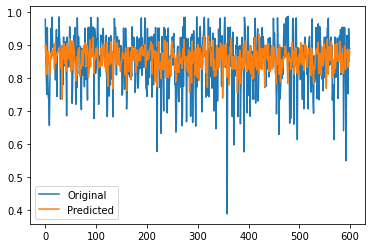

In [23]:
plt.plot(Y_test_st, label='Original')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [64]:
# Predicting  Long Term Memoriability Score
import xgboost as xgb
Y_lt = ground_truth[['long-term_memorability']].values # st targets
X = np.concatenate((feature_C3D,feature_HMP), axis=1)

from sklearn.model_selection import train_test_split
X_train_lt, X_test_lt, Y_train_lt, Y_test_lt = train_test_split(X,Y_lt, test_size=0.1, random_state=42) 

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X_train_lt, Y_train_lt)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [65]:
#predict for stm for test set
print('Long Term:')
y_pred = model_xgb.predict(X_test_lt)
Get_score(y_pred, Y_test_lt)

Long Term:
The Spearman's rank correlation coefficient is: 0.088


#### **9.5 Predicting Using Multilayer Perceptron Model**####

Epoch 1/20
169/169 [==============================] - 2s 7ms/step - loss: 0.0933 - accuracy: 0.5805 - val_loss: 0.0323 - val_accuracy: 0.6950
Epoch 2/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0428 - accuracy: 0.5965 - val_loss: 0.0232 - val_accuracy: 0.6950
Epoch 3/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0348 - accuracy: 0.5977 - val_loss: 0.0209 - val_accuracy: 0.6950
Epoch 4/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0302 - accuracy: 0.6307 - val_loss: 0.0193 - val_accuracy: 0.6950
Epoch 5/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0263 - accuracy: 0.6444 - val_loss: 0.0182 - val_accuracy: 0.6950
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0236 - accuracy: 0.6571 - val_loss: 0.0174 - val_accuracy: 0.6950
Epoch 7/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0228 - accuracy: 0.6649 - val_loss: 0.0167 - val_accuracy: 0.6950
Epoch 

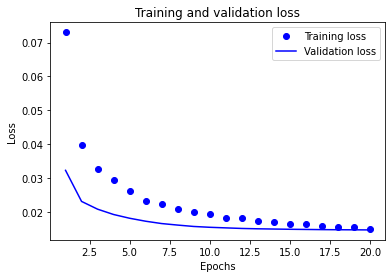

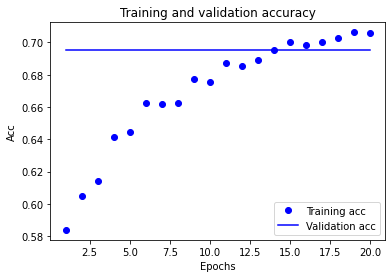

In [28]:
Y = ground_truth[['short-term_memorability','long-term_memorability']].values
X = np.concatenate((feature_C3D,feature_HMP), axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
## Multi Layer perceptron Model 

model=Sequential() # Create Sequential NN model

## Add layers for MLP
model.add(layers.Dropout(0.6, input_shape=(X.shape[1],))) # add dropout layer

# layer of 10 neurons with selu activation function, L2 Regularization and initial weights as zeros
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001), kernel_initializer='zeros')) 

# layer of 10 neurons with selu activation function and L2 Regularization
model.add(layers.Dense(10,activation='selu',kernel_regularizer=regularizers.l2(0.001)))

# add dropout
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2,activation='sigmoid')) ## Last activation as sigmoid to predict score

## Compile the model 
# Optimizer Adamax
model.compile(optimizer='adamax',loss='mse',metrics=['accuracy'])


## Training the model 
history = model.fit(X_train,Y_train,epochs=20, validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [29]:
Y_prediction_val = model.predict(X_test)
Get_score(Y_prediction_val,Y_test)

The Spearman's rank correlation coefficient is: 0.306
The Spearman's rank correlation coefficient is: 0.155


###**10 Selecting the Best Model for Prediction on Test Set**###

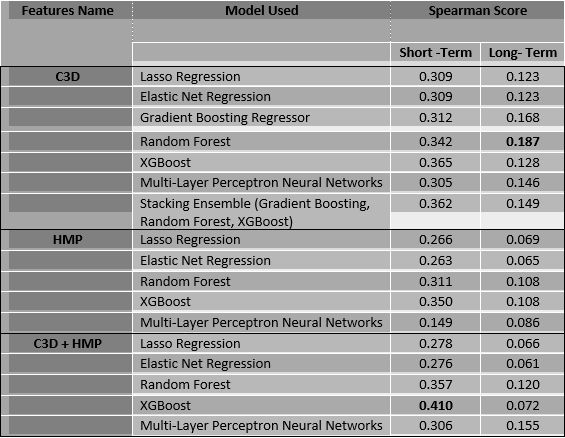

In [111]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Prediction Score.PNG",width="600",height="400")

#### **Note:** As we can see from above Table **XGBoost** gave best results for Short Term Memorability and **Random Forest** for Long Term Memorability so I will use these models individually to train on my Test set to predict Short and Long Term Memorability Score.####

####**10.1 Declaring the Source Path and Variable for Loading Test Set Data**####

In [25]:
os.chdir('/content/drive/My Drive/CA684_Assignment/Test-set/')
!ls

aesthetic_vis_features_test  ColorHistogram_test  HOG_test	  ORB_test
C3D_test		     Ground-truth_test	  Inception_test  README.txt
Captions_test		     HMP_test		  LBP_test


In [28]:
!pwd

/content/drive/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Test-set


####**10.2 Loading Features from Test Set(C3D,HMP) and Ground Truth**#### 

In [38]:
ground_truth_test_loc = 'Ground-truth_test/ground_truth_template.csv'
ground_truth_test=pd.read_csv(ground_truth_test_loc)

#Overwriting the Feat_Path to test dataset location
Features_path = '/content/drive/My Drive/CA684_Assignment/Test-set/'

In [63]:
ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [39]:
#Overwriting the functions for getting dataset name and full path since directory is named feature_test
def getnames(featurename):
  vnames = os.listdir(Features_path+featurename+'_test')
  return vnames

def getpaths(featurename):
  fpath = [Features_path+featurename+'_test/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [40]:
#Loading 2000 test set of C3D
feature_C3D_test = devset_df_C3D()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7494.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7495.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7496.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7497.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/video7498.txt']
Loading C3D
done


In [41]:

#Loading 2000 test set of HMP
feature_HMP_test = devset_df_HMP()

Feature Path:
['/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7494.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7495.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7496.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7497.txt', '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/video7498.txt']
Loading HMP
done


In [43]:
print('Shape of C3D Test Set:', feature_C3D_test.shape)
print('Shape of HMP Test Set:', feature_HMP_test.shape)

Shape of C3D Test Set: (2000, 101)
Shape of HMP Test Set: (2000, 6075)


In [53]:
X_train = np.concatenate((feature_C3D,feature_HMP), axis=1)
X_test = np.concatenate((feature_C3D_test,feature_HMP_test), axis=1)
Y_train_short = ground_truth[['short-term_memorability']].values
Y_train_long = ground_truth[['long-term_memorability']].values
Y_test = []

####**10.4 Predicting Short Term Memorability Score Using XGBoost Model**####

In [54]:
# Predicting Short Term Memorability Score
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X_train, Y_train_short)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [55]:
#predict for stm for test set
prediction_XGB_test = model_xgb.predict(X_test)

In [58]:
# We get array of short term memorability score
print(prediction_XGB_test)

[0.8584278  0.838166   0.8673552  ... 0.8903736  0.8238578  0.89494324]


####**10.5 Predicting Long Term Memorability Score Using Random Forest**####

In [59]:
rf_regressor = RandomForestRegressor(n_estimators=400,random_state=42,verbose=2,n_jobs=-1)
rf_regressor.fit(X_train,Y_train_long)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.0min


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 42.2min


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 95.5min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 105.6min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [60]:
#predict for ltm for test set
prediction_RF_test = rf_regressor.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.5s finished


In [61]:
# We get array of Long term memorability score
print(prediction_RF_test)

[0.7806125 0.7714525 0.7732125 ... 0.8107    0.77243   0.82232  ]


In [82]:
#Function to convert row-wise 1D array to 2D Column-wise array

prediction_XGB_test_concat = np.vstack((prediction_XGB_test))
prediction_RF_test_concat= np.vstack((prediction_RF_test))

In [83]:
print(prediction_XGB_test_concat)

[[0.8584278 ]
 [0.838166  ]
 [0.8673552 ]
 ...
 [0.8903736 ]
 [0.8238578 ]
 [0.89494324]]


In [84]:
#print(prediction_RF_test_concat)

[[0.7806125]
 [0.7714525]
 [0.7732125]
 ...
 [0.8107   ]
 [0.77243  ]
 [0.82232  ]]


In [87]:
# Here we concatenate the 2d array of Short term and Long Term

Final_Features = np.concatenate((prediction_XGB_test_concat,prediction_RF_test_concat),axis=1)

In [88]:
print(Final_Features)

[[0.85842782 0.7806125 ]
 [0.838166   0.7714525 ]
 [0.86735523 0.7732125 ]
 ...
 [0.89037359 0.8107    ]
 [0.82385778 0.77243   ]
 [0.89494324 0.82232   ]]


In [89]:
#Function to store short term and Long Term score in Test Ground truth

Prediction_Test = pd.DataFrame({'video': natsorted(ground_truth_test['video']),
                    'short-term_memorability': [row[0] for row in Final_Features],
                    'long-term_memorability':[row[1] for row in Final_Features]
                        })

In [90]:
Prediction_Test.head()

,video,short-term_memorability,long-term_memorability
0,7494,0.858428,0.780613
1,7495,0.838166,0.771453
2,7496,0.867355,0.773213
3,7497,0.899381,0.804452
4,7498,0.780464,0.753865


In [91]:
Prediction_Test.shape

(2000, 3)

In [92]:
Prediction_Test.to_csv('/content/drive/My Drive/final_predictions.csv')